### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Fall 2018 ###

# Automotive Inspection with the Laser Radar #

#### Kartik Sreenivasan (ksreenivasa2@wisc.edu 9079923174) 
#### Matthew Crepea (crepea@wisc.edu 9080086573)
#### Talha Sultan (tsultan@wisc.edu 9070304564) 
#### Eric Brandt (elbrandt@wisc.edu 9080120612)


### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
 1. [Scan Path Results](#4.1-Scan-Path-Results)
 1. [Location, Location, Location](#4.2-Location,-Location,-Location)
 1. [Double the Fun](#4.3-Double-the-Fun)
1. [Conclusion](#5.-Conclusion)
1. [Appendix](#6.-Appendix)

## 1. Introduction ##

The [Nikon Laser Radar](https://www.nikonmetrology.com/en-us/product/laser-radar-mv331-351) is a high accuracy, large volume, non-contact, 3D measurement device that is gaining considerable adoption in the automotive industry for [in-line car body inspection](https://www.youtube.com/watch?v=odIYMRyCFDo). This inspection has traditionally been done with a tactile CMM which is a slow process requiring one-of-every-N cars to be spurred off the main assembly line into a carefully controlled 'measurement room'. Automotive manufacturers [can achieve considerable cost and time savings](http://www.nikonmetrology.com/en-gb/product/laser-radar-shop-floor-cmm) by switching to a robot-mounted laser-based measurement system such as the Laser Radar to inspect *all* part instances in-line, without special 1-of-N measurement followed by generalizing results to the remainder of the unmeasured instances. The laser-based measurement technology is mature, however, this relatively new adoption by the short cycle-time automotive industry has placed new pressure on maximizing the quantity and quality of feature measurements that can be made in short, fixed time windows common in assembly line manufacturing. By applying optimization techniques to the measurement plan and process, we can to increase both the quality and quantity of measurements that can be made in a fixed time window.

Automotive engineers routinely specify geometric features that must be inspected on a car when it is in the [Body-In-White](https://en.wikipedia.org/wiki/Body_in_white) phase of manufacturing. Inspection involves measuring the 3D locations and dimensions of 200-300 holes, slots, studs, surfaces, etc relative to fixed locations on the car. The measured location of these features are compared to the nominal locations specified in the CAD drawings. [Statistical process control](https://www.itl.nist.gov/div898/handbook/pmc/section1/pmc12.htm) calculations are performed to evaluate the overal accuracy, precision, reliability, and repeatability of the manufacturing process. The task of scanning each feature and extracting the location of the measured geometry relative to a global ‘car coordinate system’ is well handled by existing software.
![Nikon Laser Radar](LR_Combo.jpg)

However, the process of deciding *how* to measure these features using the Laser Radar is a decision largely made by manufacturing engineers using 'rule-of-thumb' techniques based on their experience with robot and tactile CMM programming. Often these engineers have little experience with laser based measurement systems. The opportunity to optimize this scenario lies in several sub-problems, which we model, solve, and discuss:

1. *Determine the optimal order in which to measure a list of features.* Pointing the measuring laser of the device to each feature location requires moving a mirror in azimuth and elevation, both of which have known velocity and acceleration profiles and limits. The optimization task is: For a given fixed laser radar location relative to the car, find an ordering of a given list of features to be measured that minimizes total measurement time.

2. *The optimal order depends on the location of the Laser Radar* The laser radar measures by directing its mirror in two axis, forming a spherical coordinate system. The time it takes to move the laser from one target location to another is not dependent on the cartesian distance between the two targets, but rather a function of the angular separation of the features from the perspective of the Laser Radar. This function will be investigated.

3. *Determine the optimal order if **two** Laser Radars are available to measure* If the measurement cell had two Laser Radars located at fixed positions, and list of $n$ features to measure. If they could work simultaneously, each measuring seprate features, what is the shortest amount of time in which the job could be completed? Which features should each Laser Radar measure? How can we divide the features between two Laser Radars, and simulaneously order those features for each Laser Radar such that the *maximum* measurement time of each of the two Laser Radars is *minimized*.


### 1.1 Data Source

We reached out to Nikon Meteorology's marketing department to ask for use of a CAD file with the example Car Body-In-White Model used in the [promotional video above](https://www.youtube.com/watch?v=odIYMRyCFDo). They have generously provided us with this file for use in this project. From this CAD model we were able to extract a list of car features, including their locations and orientations, to be used in the optimization models below.

### 1.2 Report Outline

- In [Section 2](#2.-Mathematical-model) we outline the preprocessing that must be done on our given data, and detail the optimization models that we use to solve the above problems.
- In [Section 3](#3.-Solution) we implement our solution in Julia, using JuMP.
- In [Section 4](#4.-Results-and-discussion) we discuss the results of running our optimizaiton models, and provide visualizations for the output on top of the CAD Model provided to us.
- In [Section 5](#5.-Conclusion) we review our results and provide some future steps for this project.
- In [Section 6](#6.-Appendix) we detail some of the different formulations for the Travelling Salesmen Problem that we attempted, and give comparisons for their respective running times.

### 1.3 Key Assumptions

To simplify our modeling, we make the following key assumptions:

- The physical location of the Laser Radar is given as a paremeter in the optimization procedure, and the Laser Radar does not move.
- The accuracy of a reading for a given feature from the Laser Radar is the same regardless of what the incidence angle of the laser to the feature is.
- We ignore Line of Sight constraints in our modeling, making the assumption that the Laser Radar is positioned in such a way that it can scan all of the features provided to it in the optimization procedure.

## 2. Mathematical model ##

### 2.1 Coordinate Systems
Within the work cell, there are many coordinate systems being used. To keep the focus of this work on the optimization component, we will simplify the work cell to two fundamental coordinate systems: The Part Coordinate System (PCS), and Machine Coordinate System (MCS). It is important to understand each and be able to freely convert points in space between these coordinate systems.

* **Part coordinate system (PCS)**: This is a 3D Cartesian coordinate system that is the same coordinate system the engineer used in CAD to design the car. In our models, this coordinate system has its origin on the centerline of the car, both side-to-side and front-to-back, and is located underneath the car. The Z-axis is points toward the front of the car, and the Y-axis points upward. Being a right-handed coordinate system, this leaves the X-axis to points toward the driver's side door.  All features to be measured are defined in this coordinate system. Also, the location and orientation of the Laser Radar in the work cell is specified in this coordinate system.
![Part Coordinate System](PCS.png)

* **Machine coordinate system (MCS)**: This is the coordinate system from the viewpoint of the Laser Radar. (The historical name 'Machine' comes from the world of CNC and tactile CMM devices). The Laser Radar measures in a [spherical coordinate system](https://en.wikipedia.org/wiki/Spherical_coordinate_system): It measures *range* using reflected signal from an IR laser, and the laser itself can be 'steered' in *azimuth* and *elevation* by means of a motorized mirror that spins on one axis and pivots on an orthoganal axis. The *azimuth*, or $\phi$, ranges from -180 to 180 degrees $(-\pi, \pi)$, with 0 being the front of the Laser Radar. The *elevation*, or $\theta$, ranges from -45 to +45 degrees relative to horizontal. To stay with standard ISO spherical coordinate conventions, we will define this as $\theta$, to be measured as the inclination angle, or the angle relative to vertical, giving it a valid range of $(\frac{\pi}{4}, \frac{3\pi}{4})$, with $\frac{\pi}{2}$ being horizontal. See diagram below (courtesy Wikipedia). The $\phi$ and $\theta$ angles of the mirror are recorded by two highly accurate encoders inside the Laser Radar, and when synchronized with the laser's range measurement, form a spherical coordinate triple $(r, \theta, \phi)$ that originates from the center of the mirror on the laser radar.
![Spherical Coordinate System](SphericalCS.png)

The first transformation required for optimzation is converting Spherical MCS to Cartesian MCS. This is accomplished using standard trigonometry:
\begin{align*}
x &= r \sin \theta \cos \phi \\
y &= r \sin \theta \sin \phi \\
z &= r \cos \theta
\end{align*}
And likewise, we can convert Cartesian MCS to Spherical MCS:
\begin{align*}
r &= \sqrt{x^2 + y^2 + z^2} \\
\theta &= \arccos\frac{z}{\sqrt{x^2 + y^2 + z^2}} = \arctan \frac{\sqrt{x^2+y^2}}{z}\\
\phi &= \arctan \frac{y}{x} \\
\end{align*}

Note the manipulation of $\theta$ by trig identities to reformulate using the $\arctan$ function. For correct results in quadrants 2 and 4, it is necessary to use the function `atan2()` programmatically to account for sign changes.

The second transformation required for optimization is converting Cartesian MCS to PCS. This is accomplished via a standard 3D affine transformation. We define the location and orientation of the Laser Radar within the part coordinate system according to a homogeneous transformation matrix. If the Laser Radar's orientation is described by its 3 orthogonal axis $X$, $Y$, and $Z$ as orthonormal vectors $U$, $V$, and $W$ in PCS, and the Laser Radar's mirror center is described in PCS as point $(LR_x, LR_y, LR_z)$, then the matrix that transforms a point in Cartesian MCS point to the same point in PCS is 
\begin{equation*}
T_{\text{MCS to PCS}} = \begin{bmatrix} 
U_x & V_x & W_x & LR_x \\
U_y & V_y & W_y & LR_y \\
U_z & V_z & W_z & LR_z \\
0   & 0   & 0   & 1
\end{bmatrix}
\end{equation*}
And, of course, the matrix that transforms PCS points to Cartesian MCS points is simply the inverse:
\begin{equation*}
T_{\text{PCS to MCS}} = T_{\text{MCS to PCS}}^{-1} 
\end{equation*}

### 2.2 Measurement Feature Definitions

#### 2.2.1 Feature CSV Files

In this problem, we are given a list of features on the Car Body that must be scanned by the Nikon Laser Radar. Since these features are extracted directed from the CAD figures of the Car Body, they are given to us in the Cartesian PCS coordinate system. For a given features $X_i$, we are given

* The Feature Type - This is what the laser is measuring. This can be Hole, Slot, Stud, Rectangle, Surface Vector, or Sphere.
* $(X, Y, Z)$ - The cartesian coordinates of the feature in the PCS coordinate system.
* $(I, J, K)$ - The normal vector of the feature in PCS.

An example of one of the feature csv files that we use in this problem is *50_Holes_FrontLeft.csv*. These features in this file can be visualized on the car shown here:
![50_Holes_FrontLeft](50_Holes_FrontLeft.png)

#### 2.2.2 Laser Radar Location CSV Files

We are also given different potential locations and orientations for the Laser Radar, from which it will scan the car. These are in the files *Location1.csv*, *LocationLeft.csv*, and *LocationRight.csv*. Each one of these files contains a 4x4 matrix in the format of a $T_{\text{MCS to PCS}}$ matrix seen above that encode the location and orientation of the Laser Radar. As shown below, we can use this to transform the $(X, Y, Z)$ feature coordinates in the PCS coordinate system to cartesian coordinates in the MCS coordinate system.

Notably, when solving the shortest path problem for different locations of the Laser Radar, we get different solutions (See Section **4.2 Location, Location, Location (of the LR)**).


### 2.3 Laser Radar Motion

For the purposes of this project, we assume that the Nikon Laser Radar remains stationary and can rotate its laser in azimuth and elevation to create a scanning path through all of the required features of the car body. We relax the problem here by ignoring acceleration of the motorized mirror, as we believe this to be negligible. However, the Laser Radar is capable of rotating in azimuth and elevation simultaneously, which we must incorporate into our model. To do so, we first map each feature $X_i$ into Spherical Coordinates relative to the MCS as follows:

$X_{\text{i, MCS Cartesian}} = T_{\text{PCS to MCS}} * X_{\text{i, PCS Cartesian}}$

From here, we can find the Spherical Coordinates $(r_{\text{i, MCS}}, \theta_{\text{i, MCS}}, \phi_{\text{i, MCS}})$ using the trigonometric equations described above.

From this, we can convert our list of features $\{X_i\}_{i=1}^{\text{Number Features}}$ into spherical coordinates.

For any two features, $X_i, X_j$, we can calculate the time for the Laser Radar to travel between them as follows:

* Assume that the Laser Radar starts at either point $X_i$ or $X_j$, and it immediately begins rotating in both azimuth *and* elevation to the other point.
* We assume that the Laser Radar rotates in azimuth with speed $v_{\text{azimuth}}$ radians per second, and rotates in elevation with speed $v_{\text{elevation}}$ radians per second.
* The time that it will take to rotate in azimuth is

\begin{equation*}
\frac{|\phi_i - \phi_j|}{v_{\text{elevation}}}
\end{equation*}

* Similarly, the time that it takes to rotate in elevation is

\begin{equation*}
\frac{|\theta_i - \theta_j|}{v_{\text{azimuth}}}
\end{equation*}

* Since the Laser Radar moves in both of these directions simultaneously, the time it takes to travel from feature $X_i$ to feature $X_j$ is the maximum of these two quantities, or the *Inifnity Norm* of the vector of travel times of each direction in spherical coordinates. Specifically, this is:

\begin{equation*}
t_{i,j} = \big\Vert\frac{\theta_i - \theta_j}{v_{\text{elevation}}}, \frac{\phi_i - \phi_j}{v_{\text{azimuth}}}\big\Vert_{\infty}
\end{equation*}

For the scope of this project, we simply set $v_{\text{elevation}} = v_{\text{azimuth}} = 1\frac{radian}{second}$. However, this formulation is flexible enough that it would allow an Automotive Engineer to substitute in the speeds for their own Laser Radars, and calculate the correct solution with respect to their setup.

Additionally, we neglected the to include time that it takes to adjust the *range* $r_{\text{MCS}}$ of the laser between two features because in practice this adjustment time is negligible compared to the time needed to adjust the elevation and azimuth of the laser. We see later on that this impacts how the optimal feature paths are constructed.

### 2.4 Optimal Measurement Plan Path

### 2.4.1 Formulating as TSP problem

**Inputs:** 
* _LR Location/orientation matrix_: The location and orientation of the laser radar with respect to the features to be measured is critical in determining the cost matrix because the nodes to visit are defined in spherical coordinates relative to the mirror of the laser radar.
* _Mirror Azimuth and Elevation velocities_: These velocities determine how fast the laser radar can move its measurement laser from one location to another. For this model, we assume instantaneous acceleration to start and stop the mirror, and constant velocity during travel. This is reasonable for this model because the mirror assembly has relatively low mass and low moment of inertia, so accelerations are fast.
* _Unordered site location list:_ (csv file containing points to visit) This defines the location of the features to be measured in spherical coordinates with respect to the Laser Radar's mirror. The feature definition file described above contains feature locations in cartesian coordinates relative to the car's coordinate system. Before constructing the cost matrix, these cartesian coordinates must be converted to spherical coordinates relative to the Laser Radar's coordinate system. This transformation is described above. This is essential since the time taken for the laser to move from one feature to another depends on the position of the LR. In other words, the costs between nodes in the TSP vary with the position of the LR.

**Output:**
* _Optimal Ordered Site Visiting List_: This is the optimal ordering of sites produced by the solved TSP; this makes up the optimal path for the Laser Radar to follow to minimize the total time for a single scan.
* _Minimal Scan Time_: This is the amount of time that it will take to scan all of the features, using the given optimal path.

**Assumptions:**
* We assume that we can start from anywhere. That is, the time it takes the Laser Radar to travel from its arbitrary resting location to the first point is not included in our calculation
* We only wish to visit all points and then terminate after reaching the last point. We do not wish to return to the start.
* We assume that the Laser Radar has been positioned to have line-of-sight visibility to all features to be measured. That is, the laser's path to each of the featuresis not occluded by other physical objects.

**Cost Matrix:**
* _Travel Time Matrix_: As seen above, we can compute the distance between two features $X_i$, $X_j$ by first converting their PCS coordinates into MCS coordinates; then, converting these into MCS spherical coordinates, and then finally taking the infinity norm over the azimuth travel time and elevation travel time for the two features. By iterating over all pairs of features $X_i$, $X_j$ in our dataset, we can construct a cost matrix $C^{NxN}$ such that $C_{i,j}$ is the travel time between features $X_i$ and $X_j$; this is simply $t_{i,j}$ as calculated above. By precomputing this cost matrix, we can solve the computational geometry portion of this problem entirely in the preprocessing step, leaving the remainder of this problem to be solved as a standard Travelling Salesman Problem (TSP).

**Optimization Algorithm**:

Once the inputs are properly defined, and a cost matrix is constructed, TSP algorithm can be applied. In our implementation, we implemented four different TSP algorithms:
1. MTZ formulation (from class lecture)
2. Iterative Subtour Elimination (from class lecture)
3. Subtour Elmination using Lazy Constraints (based on 2, but using additional JuMP/Gurobi capability of `@lazyconstraint`)
4. Symmetric Matrix & Lazy Subtour Elimination (based on Gurobi website [example](http://examples.gurobi.com/traveling-salesman-problem/))

We evaluated the performance of each, and settled on \#4 - the Symmetrix Matrix with Lazy Subtour Elimination algorithm. Therefore, only this algorithm will be discussed here, but a thorough comparison of all four can be seen in the [Appendix](#6.-Appendix). The high-level results of this evaluation are also discussed in [Section 4](#4.-Results-and-discussion).

### 2.4.2 Optimization Algorithm - Decision Variables

Given our set of $N$ site locations $\{X_i\}_{i=1}^{N}$ for the Laser Radar to scan, we wish to construct the Optimal Scanning Path between them. We can first generate the Cost Matrix $C^{NxN}$ that encodes the travel time between each of the N features. Effectively, this is now reducible to the TSP Problem, as we wish to find the minimal travel time for a path connecting our N features. In a similar manner to other TSP formulations, we encode the selected path in a Symmetric Binary Matrix $Z^{NxN}$, such that

* $Z_{i,j} = Z_{j,i} = 1$ if there is an edge between $X_i$, $X_j$ in the optimal search path.
* $Z_{i,j} = Z_{j,i} = 0$ if there is no edge between $X_i$, $X_j$ in the optimal search path.

Here, Z is the Decision Variable for the optimization problem.

Something notable in our formulation is that $Z_{i,j} = Z_{j,i}, \forall i,j \in \{1, ..., N\}$. Effectively, this means that we are creating an undirected graph instead of a directed one. Then from this solution we can extract one of two optimal paths, which simply are the reverse of eachother.

For this problem particularly, we decided that this was a reasonable assumption because our Cost Matrix C is symmetric itself, so both optimal solutions (forwards and backwards) will take the same time to scan. Therefore we can pick one of these two paths arbitrarily and still recover an optimal path to minimize scan time.

One of the benefits of using an undirected graph formulation is that in the subtour elimination part of the solution, we only have to remove a given subtour once. In practice, we found that without this simplification we would often see that same subtours appearing twice, with the second one being a reverse ordering of this first. By using this formulation of the problem we effectively cut the number of iterations that we must do to find an optimal solution without subtours down by half.

### 2.4.3 Optimization Algorithm - Constraints

The choice to use an undirected graph also changes how we represent our *Indregree* and *Outdegree* constraints. In previous formulations for the TSP Problem we explicit constraints on each node $X_i$ such that

\begin{equation*}
Indegree(X_i) = 1, \forall i \in \{1,...,N\}
\end{equation*}

\begin{equation*}
Outdegree(X_i) = 1, \forall i \in \{1,...,N\}
\end{equation*}

Since we use an undirected graph, we simply need to state the the *Degree* of each node $X_i$ is 2 (we can afford to do this because creating an incoming edge forces an outoging edge by the symmetric formulation); we can encode with the following constraint:

\begin{equation*}
\sum_{j=1}^{N} Z_{i,j} = 2, \forall i \in \{1,...,N\}
\end{equation*}

We also retain the constraint can have no path to itself:

\begin{equation*}
Z_{i,i} = 0, \forall i \in \{1,...,N\}
\end{equation*}

Finally, any time that we solve this problem and encounted a *Subtour* in our solution, $\{X_{S1}, X_{S2}, ..., X_{Sk}\}$ such that $\{k < n\}$, we encode a constraint in our model to explicitly disallow *this particular subtour*:

\begin{equation*}
\sum_{i = 1}^{k} \sum_{j = 1}^{k} Z_{Si, Sj} \leq k -1
\end{equation*}

Notably, this constraint not only disallows *this particular subtour*, but also *all possible subtours that can be formed out of these k nodes*. This is different than the standard Subtour Elimination Constraint that was discussed in lecture, but we found that this formulation for the Subtour Elimination Constraint dramatically reduced the computational time needed to solve the problem. Further discussion on the differences in efficiency between different problem formulations can be found in [Section 4](#4.-Results-and-discussion) and in the [Appendix](#6.-Appendix).

### 2.4.4 Optimization Algorithm - Objective

We Minimize the traditional objective function used in TSPs,

\begin{equation*}
\frac{1}{2}\sum_{i = 1}^{N} \sum_{j = 1}^{N} C_{i, j}Z_{i, j}
\end{equation*}

Here $Z_{i,j} = 1$ when we have selected the use the path between sites $X_i$, $X_j$ and $C_{i,j}$ is the travel time of that path. The sum over all $Z_{i,j}C_{i,j}$ then is the total travel time for the path.

Notably, we divide this sum by 2 here because we are still using the undirected graph formulation, so every edge is technically counted twice; dividing by 2 corrects for the double counting.

### 2.4.5 Optimization Algorithm - Full Formulation

In total,

We wish to minimize

\begin{equation*}
\min_{Z^{NxN}}\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j}
\end{equation*}

Subject to

* Degree = 2 Constraint:

\begin{equation*}
\sum_{j=1}^{N} Z_{i,j} = 2, \forall i \in \{1,...,N\}
\end{equation*}

* No Self-Loop Constraint:

\begin{equation*}
Z_{i,i} = 0, \forall i \in \{1,...,N\}
\end{equation*}

* Z is a Binary, Symmetric Matrix

\begin{equation*}
Z_{i,j} \in \{0,1\}, \forall i \in \{1,...,N\}, j \in \{1,...,N\}
\end{equation*}
\begin{equation*}
Z_{i,j} = Z_{j,i}, \forall i \in \{1,...,N\}, j \in \{1,...,N\}
\end{equation*}

* Whenever we encounter a solution with a subtour $\{X_{S1}, X_{S2}, ..., X_{Sk}\}$, we impose the Subtour Elimination Constraint:

\begin{equation*}
\sum_{i = 1}^{k} \sum_{j = 1}^{k} Z_{Si, Sj} \leq k -1
\end{equation*}

### 2.4.6 Optimizing 'Path' versus 'Tour'

Because we are only interested in quickly measuring each feature (visiting each site), we have no interest in returning to the first site at the conclusion of the measurement. The next job for the Laser Radar is not likely to be the same sequence of measurements, so we do not care where the laser is pointing at the conclusion of the measurement. Therefore, we desire a 'path' rather than a 'tour'.

To modify the TSP algorithm to produce a 'path' rather than a 'tour', we made the following changes:
1. Add an additional 'dummy point' to the list of points to visit.
2. Append a row and column to the cost matrix so that the cost to travel from any real point to the 'dummy point' is 0. 
3. This node with zero cost to everywhere gives a 'free pass' for the laser to move from any one single feature to any one single other feature with zero cost (by traveling through the 'dummy point'). The optimization algorithm will naturally choose to take this zero-cost path instead of the most expensive path in its solution under consideration.
4. Solve as usual, and produce the best order to visit the points.
5. Left-shift (with wrap-around) the output order until the dummy point is at the head of the list. The point *after* the dummy point will be the starting point of the path, and the point *before* the dummy point will be the finishing point.
6. Remove the dummy point that is now at the head of the list. This is the optimal 'path' order.
(Note: Solving the TSP problem without a dummy node and simply discarding the final return cost may not be optimal. The algorithm might end up discarding a good solution just because the final return to "home" might be too expensive)

## 2.5 Optimizing Two Laser Radars

In case of the 2 LR problem where we have two Laser Radars avaiable to simultaneously measure the feature set, we retain much of the previous formulation but add some critical pieces. If the two LRs were located at the same position one can consider the 2 LR problem as solving a TSP where we are allowed to have 2 subtours that span the entire set of nodes. But, our case is more complicated because the 2 LRs have different cost matrices associated with them because they are at different positions.

### 2.5.1 Formulation as a TSP Problem

**Inputs:** 
* _LR Locations/orientation matrices_: The location and orientation of the two laser radars with respect to the features to be measured. Note that we now have two cost matrices as opposed to one in the previous case. This is the critical aspect of the problem that makes it interesting. The cost matrices are bound to be different for the two LRs since the "distance" between two features is _different_ for the two LRs. 
* _Mirror Azimuth and Elevation velocities_: We retain this from the previous formulation and assume both LRs are identical. (Changing this is trivial as it would only affect the cost matrix)
* _Unordered site location list:_ (csv file containing points to visit). This remains the same as well.

**Output:**
* _Optimal Ordered Site Visiting List for each LR_: This is the optimal ordering of sites produced by the solved TSP; this makes up the optimal path for each Laser Radar to follow to minimize the total time for a single scan. Note that each LR need not scan all features, just that the union of the features scanned by the two LRs must be the entire feature set.
* _Minimal Scan Time_: This is the amount of time that it will take to scan all of the features, using the given optimal path. This will be the maximum of the time required for each single LR to complete it's "subscan" since both LRs scan features simultaneously. (We use the epigraph trick to formulate this)

**Assumptions:**
* We assume that we can start from anywhere. That is, the time it takes each Laser Radar to travel from its arbitrary resting location to the first point is not included in our calculation
* We only wish to visit all points and then terminate after reaching the last point. We do not wish to return to the start. This holds true for both LRs.
* We assume that both Laser Radars have been positioned to have line-of-sight visibility to all features to be measured.

**Cost Matrices:**
* _Travel Time Matrices_: We compute the Cost Matrix for both LRs in the same manner as we did above. The problem then resolves to solving two TSPs where the desired minimal cost is the maximum of the cost of the two problems and the requirement is that the union of the nodes covered by the two TSPs is equal to the total set of nodes. Note that optimality ensures that this requires that each feature be measured only once since having the other LR measuring adds unnecessary cost.

**Optimization Algorithm**:

The problem essentially boils down to two simultaneous TSP problems with an array of binary 'selector' variables to track which LR measures a given feature. We modify the objective to take into account the maximum cost of the two subtours. We discuss this in more detail below.
Although we established that #4 is the most efficient, in this problem the presence of empty rows (other LR measures that feature), causes the formulation in this manner to be complicated. Hence we go back to non-symmetric formulation from #3.


### 2.5.2 Optimization Algorithm: Decision Variables:
Given our set of $N$ site locations $\{X_i\}_{i=1}^{N}$ for the two Laser Radars to scan. We generate two Cost Matrices $C_1^{NxN}$ and $C_2^{NxN}$ that encodes the travel time between each of the N features for the respective LRs. We create two Binary Matrices $Z_1^{NxN}$ and $Z_2^{NxN}$ that represent the paths taken by the two LRs such that:

* $Z_{k_{i,j}} = 1$ if there is an edge from $X_i$ to $X_j$ in the optimal search path traced by LR $k$, $k \in \{1, 2\}$.
* $Z_{k_{i,j}} = 0$ if there is no edge from $X_i$ to $X_j$ in the optimal search path traced by LR $k$, $k \in \{1, 2\}$.

Here, $Z_1$ and $Z_2$ are the Decision Variables for the optimization problem.

Note that both $Z_1$ and $Z_2$ are different from the Z matrix we used as a decision variable in the previous problem since they are no longer symmetric. Also, we need an additional set of binary variables to track which feature is being measured by which LR.
For this, we create a vector $S^{Nx1}$ such that:

* $S_{i} = 1$ if LR-1 scans feature $i$.
* $S_{i} = 0$ if LR-2 scans feature $i$.

Note that the choice of LR-1 and LR-2 is arbitrary. This variable is essential to this formulation since it changes the constraints that ensure that each feature is measured. Some rows can sum up to zero now since that feature may be measured by the other LR.

### 2.5.3 Optimization Algorithm - Constraints

Since we go back to using a directed graph we go back to the class formulation and use *Indregree* and *Outdegree* constraints. For each node $X_i$ measured by LR-1 we impose constraints such that

\begin{equation*}
Indegree(X_i) = S_i
\end{equation*}

\begin{equation*}
Outdegree(X_i) = S_i
\end{equation*}

And for each node $X_j$ measured by LR-2 we impose:

\begin{equation*}
Indegree(X_j) = S_j
\end{equation*}

\begin{equation*}
Outdegree(X_j) = S_j
\end{equation*}

Also, there can be no self loops:

\begin{equation*}
Z_{k_{i,i}} = 0, \forall i \in \{1,...,N\}, \forall k \in \{1,2\}
\end{equation*}

Finally, any time that we solve this problem and encounted a *Subtour* in our solution for LR-1 say, $\{X_{1}, X_{2}, ..., X_{k}\} = Sub$ such that $\{k < n\}$, we encode a constraint in our model to explicitly disallow *this particular subtour*. However, since the formulation is no longer symmetric, we also explicitly disallow the *reverse subtour* to potentially save ourself one iteration every time:

\begin{equation*}
\sum_{(i, j) \in Sub} Z_{1_{i, j}} \leq k - 1\\
\sum_{(i, j) \in Sub} Z_{1_{j, i}} \leq k - 1\\
\end{equation*}

If the subtour is in LR-2, we repeat the above constraint but replace the decision variable $Z_1$ with $Z_2$.

Note that this constraint is nowhere as efficient as the subtour elimination constraint from the symmetric formulation since it only excludes one particular subtour. In a vague sense, it is "exponentially" worse than the subtour elimination constraint in the previous case since we require to an exponential number of these constraints to eliminate the same number of subtours as the other case.

### 2.5.4 Optimization Algorithm - Objective

We no longer optimize the same objective as the traditional TSP since we have two subtours happening simultaneously. We wish to minimize the maximum of the costs of the two subtours since the total time spent on measuring the features is simply equal to time spent on the larger tour. To do this, we use the epigraph trick. We minimize $t$ such that:

\begin{equation*}
t \ge \sum_{i = 1}^{N} \sum_{j = 1}^{N} C_{k_{i, j}}Z_{1_{i, j}}\\
t \ge \sum_{i = 1}^{N} \sum_{j = 1}^{N} C_{k_{i, j}}Z_{w_{i, j}}
\end{equation*}

Here $Z_{k_{i,j}} = 1$ when we have selected to use the path between sites $X_i$, $X_j$ in LR-k's tour and $C_{k_{i,j}}$ is the travel time of that path when measured by LR-k. The sum over all $Z_{k_{i,j}}C_{i,j}$ then is the total travel time for the path taken by LR-k. The total time taken to measure all $N$ features is the maximum of the two since both LRs work in parallel.

Note that we drop the $\frac{1}{2}$ in this case since the formulation is no longer symmetric and therefore we don't have to concern ourselves with double counting.

### 2.5.5 Optimization Algorithm - Full Formulation

In total,

We wish to minimize

\begin{equation*}
\min_{t, Z^{NxN}}t
\end{equation*}

Subject to

* Epigraph trick induced Constraint:

\begin{equation*}
t \ge \sum_{i = 1}^{N} \sum_{j = 1}^{N} C_{k_{i, j}}Z_{1_{i, j}}\\
t \ge \sum_{i = 1}^{N} \sum_{j = 1}^{N} C_{k_{i, j}}Z_{w_{i, j}}
\end{equation*}

* InDegree = 1 Constraint:

\begin{equation*}
\sum_{i=1}^{N} Z_{1_{i,j}} = S_j, \forall j \in \{1,...,N\}\\
\sum_{i=1}^{N} Z_{2_{i,j}} = 1-S_j, \forall i \in \{1,...,N\}
\end{equation*}

* OutDegree = 1 Constraint:

\begin{equation*}
\sum_{j=1}^{N} Z_{1_{i,j}} = S_i, \forall i \in \{1,...,N\}\\
\sum_{j=1}^{N} Z_{2_{i,j}} = 1-S_i, \forall i \in \{1,...,N\}
\end{equation*}

* No Self-Loop Constraint:

\begin{equation*}
Z_{k_{i,i}} = 0, \forall i \in \{1,...,N\}, k \in \{1,2\}
\end{equation*}

* Z is a Binary Matrix

\begin{equation*}
Z_{k_{i,j}} \in \{0,1\}, \forall i \in \{1,...,N\}, j \in \{1,...,N\}, k \in \{1,2\}
\end{equation*}

* S is a Binary Vector

\begin{equation*}
S_i \in \{0,1\}, \forall i \in \{1,...N\}
\end{equation*}

* Whenever we encounter a solution with a subtour $\{X_{1}, X_{2}, ..., X_{k}\} = Sub$ in the path of LR-p, we impose the Subtour Elimination Constraint:

\begin{equation*}
\sum_{(i, j) \in Sub} Z_{p_{i, j}} \leq k - 1\\
\sum_{(i, j) \in Sub} Z_{p_{j, i}} \leq k - 1\\
\end{equation*}


### 2.5.6 Optimizing 'Path' versus 'Tour'

In the two LR problem we are now interested in finding *two* 'paths' such that the two paths span the entire set of features.

Going by the previous approach, we now require 2 dummy nodes for each of the 2 LRs to get a 'free pass' back to the start. However, as expected if we simply provide two dummy nodes, the optimization quite often picks both dummy nodes within a single LR's scan to get 2 free jumps leaving the second LR to complete a full tour!

It is easy to observe however that both dummy nodes are identical. So we arbitrarily assign one of the dummy nodes to the first LR and the second one to the second LR. Let us consider the last two nodes $n$ and $n-1$ to be the dummy nodes.

We can do this by using the constraints:
\begin{equation*}
S_{n-1} = 1\\
S_{n} = 0\\
\end{equation*}

We then take the same steps described above to produce a 'path' rather than a 'tour' as our final output.

## 3. Solution ##

### 3.1 - Change of Coordinate Systems Helper Functions

Below are the functions for changing between coordinate systems, and cartestian / spherical coordinate systems, as decribed above.

In [1]:
# global constants
g_maxAngVel = 1 # move in azimuth or elevation at max rate of 1 rad / sec
g_maxScanRate = 1000 # scans points at the rate of 1000 pts/sec

# function to convert points from cartesian Part Coordiante System to cartesian Machine Coordinate System 
# input:  mcs: 4x4 transformation matrix
#         pts: nx3 list of points in PCS
# output: nx3 list of points in MCS
function pcs_to_mcs_xyz(mcs, pts)
    # transform all points into LR Cartesian coordinates
    # homogenize the pts with a 1
    qty = size(pts,1)
    tmp = [pts ones(qty,1)]
    # multiply by inverse of the LR's location/orientation
    ret = inv(mcs) * tmp'
    return ret[1:3,:]'
end;

# function to convert points from cartesian Part Coordiante System to cartesian Machine Coordinate System 
# input:  mcs: 4x4 transformation matrix
#         pts: nx3 list of points in MCS
# output: nx3 list of points in PCS
function mcs_to_pcs_xyz(mcs, pts)
    # transform all points into LR Cartesian coordinates
    # homogenize the pts with a 1
    qty = size(pts,1)
    tmp = [pts ones(qty,1)]
    # multiply by inverse of the LR's location/orientation
    ret = mcs * tmp'
    return ret[1:3,:]'
end;

# function to convert points from cartesian to spherical
# input:  pts: nx3 list of xyz (cartesian) points
# output: nx3 list of spherical points (range, theta, phi)
function xyz_to_sph(pts)
    r = [vecnorm(pts[i,:]) for i=1:size(pts,1)]
    r2= [vecnorm(pts[i,1:2]) for i=1:size(pts,1)]
    t = atan2.(r2, pts[:,3])
    p = atan2.(pts[:,2], pts[:,1])
    return [r t p]
end;

# function to convert points from spherical to cartesian
# input:  pts: nx3 list of (r,t,p) (spherical) points
# output: nx3 list of cartesian points (xyz)
function sph_to_xyz(pts)
    # multiply by inverse of the LR's location/orientation
    x = pts[:,1] .* sin.(pts[:,2]) .* cos.(pts[:,3]) # rsinθcosϕ
    y = pts[:,1] .* sin.(pts[:,2]) .* sin.(pts[:,3]) # rsinθsinϕ
    z = pts[:,1] .* cos.(pts[:,2])                   # rcosθ
    return [x y z]
end;

### 3.2 Cost Matrix

Below are functions to calculate the Travel Time/Cost Matrix

In [2]:
# function that computes the travel time from spherical coordinate 'from' to 'to'
# (assumes instantaneous acceleration to max velocity)
travel_time(from, to) = maximum(abs.((to .- from)[2:3])) / g_maxAngVel;

# function that takes a list of nx3 spherical coordinates and returns an n x n 
# matrix where A(i,j) where  the time it takes to move from point i to point j
cost_matrix(sph) = [travel_time(sph[i,:],sph[j,:]) for i=1:size(sph,1), j=1:size(sph,1)];

### 3.3 TSP Formulation

Below we encode the TSP Formulation, as well as functions for finding subtours and removing the dummy node from the search path.

Note - we make use of `@lazyconstraint()` here to add subtour constraints. This allows the solver to leverage solutions from previous iterations with subtours in finding solutions for the next iteration and avoid restarting the solver. The `tsp()` function also allows us to solve for optimal path *or* tour, depending on user input.

Note also that finding subtours is a bit more tricky in the undirected graph case than in the directed graph case. The algorithm, although straightforward in principle, involves additional bookkeeping of visited nodes and careful selection of the order of edges to traverse to find the subtours.

In [3]:
using JuMP, Gurobi

# function to detect the shortest subtour in a solution
# input: edges: A list of edges [i,j] between nodes in the undirected graph
#        n:     The number of nodes in the graph
# otuput: A list containing nodes in the shortest subtour
function find_subtour(edges, n)
    visited = [false for i=1:n]
    cycles=[]
    lengths=[]
    selected=[[] for i=1:n]
    for e in edges
        push!(selected[e[1]], e[2])
    end
    while true
        current = find(visited .== false)[1]
        thiscycle = [current]
        while true
            visited[current] = true
            neighbors = []
            for x in selected[current]
                if visited[x] == false
                    push!(neighbors, x)
                end
            end
            if length(neighbors) == 0
                break
            end
            current = neighbors[1]
            push!(thiscycle, current)
        end
        push!(cycles, thiscycle)
        push!(lengths, length(thiscycle))
        if sum(lengths) == n
            break
        end
    end
    return cycles[indmin(lengths)]
end

# function to remove the dummy node from a tour solution
# input: The tour solution
# output: Solution that removes dummy node and encodes an optimal path 
function remove_dummy_node(tour)
    len = length(tour)
    idx_dummy = indmax(tour)
    return [tour[(i+idx_dummy)%len+1] for i=0:len-2]
end

# function to solve the tsp and return the optimal tour and cost
# input: cost: NxN matrix encoding cast to travel between all nodes
#        return_to_start: Boolean value encoding whether or not we want an optimal tour or path
# output: tour: The optimal tour/path to be solved for
#         travel_time: The time it takes to travel this tour.
function tsp(cost, return_to_start)
    n = size(cost,1)
    if !return_to_start
        # if we don't need to form a loop, add a dummy node of cost 0 to everywhere.
        # our non-cyclic path will start from the node following this node
        # and end at the node preceding this node.
        cost = [cost zeros(size(cost,1),1)]
        cost = [cost ; zeros(1, size(cost,2))]
        n += 1
    end

    # TSP solve
    m = Model(solver=GurobiSolver(OutputFlag=0))    
    # use the symmetric matrix formulation & subtour elimination described at
    #  http://examples.gurobi.com/traveling-salesman-problem/
    @variable(m, z[i=1:n, j=1:n], Bin, Symmetric)
    @objective(m, Min, 0.5*sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,j] for j=1:n) == 2 ) # one in and one out edge
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self

    num_lazy_constraints = 0
    function subtour_callback(cb)
        soln = getvalue(z)
        # check for subtours
        selected = [[i,j] for i=1:n, j=1:n if soln[i,j] > 0.5]
        subtour = find_subtour(selected, n)
        if length(subtour) == n
            return
        end
        # add constraint to prohibit these subtours
        len = length(subtour)
        subtour = sort(subtour)
        num_lazy_constraints += 1
        @lazyconstraint(cb, sum( z[subtour[j],subtour[i]] for i = 1:len, j=i:len ) <= len-1)
    end

    # add the lazy constraint callback and solve
    addlazycallback(m, subtour_callback)
    solve(m)
    soln = getvalue(z)
                
    # extract feature order
    selected = [[i,j] for i=1:n, j=1:n if soln[i,j] > 0.5]
    tour = find_subtour(selected, n)
    if !return_to_start
        tour = remove_dummy_node(tour)
    end
    return [tour, getobjectivevalue(m)]
end;

### 3.4 Testing Driver

Below we have prepared driver functions that compute the cost matrix and run the *tsp* function, and display formatted prints of the output.

In [4]:
# finds minimal path to scan features given an LR location, and
# computes (simulated) scan data along that path.
# input:  features: matrix of features in feature file format.
#         lr_location: 4x4 transformation matrix of LR's position in PCS.
#         optimize: boolean indicating whether to optimize the path or not.
# output: list containing:
#           list of indices of order that the features were measured
#           time it took to travel to the entire path
#           elapsed (computational) time to optimize the path
#           simulated scan points along the path
function scan_feature_path(features, lr_location, optimize)
    # xyz location of features
    pts_pcs = convert(Array{Float64, 2}, features[:,2:4]) # feature locations in PCS

    # spherical coordinates with origin at laser radar
    sph = xyz_to_sph(pcs_to_mcs_xyz(lr_location, pts_pcs))
    cost = cost_matrix(sph) # cost to travel from feature i to feature j
    
    if optimize
        # optimize
        tm = @timed(tsp(cost, false))
    else
        # don't optimize. scan in current order
        n = size(cost,1)
        tm = @timed([[i for i=1:n], sum(cost[i,i+1] for i=1:n-1)])
    end
    tour = tm[1]
    push!(tour, tm[2])
    
    return tour
end

# test harness
function test(featureFile, locationFile)            
    features = readcsv(featureFile); # feature file
    lr_position = readcsv(locationFile) # transformation matrix for LR's positionend

    scan_no_opt = scan_feature_path(features, lr_position, false)
    scan_opt = scan_feature_path(features, lr_position, true)
    
    @printf("Feature path without optimization: %.6f sec\n", scan_no_opt[2])
    @printf("Feature path with optimization:    %.6f sec\n", scan_opt[2])
    @printf("Time savings:                      %.6f sec\n", scan_no_opt[2] - scan_opt[2])
    @printf("Optimal feature ordering:\n")
    println(scan_opt[1])
    @printf("Computational time to optimize:    %.6f sec\n", scan_opt[3])
end;

## 3.5 Two Laser Radar Optimization

Below is a function that minimizes the maximum time of two Laser Radars working simultaneously on the same set of features.

In [5]:
function TSP2_LazyIterSubtour(cost1, cost2)
    n = size(cost1,1) # number of features
    # to form a path, add a dummy node of cost 0 to everywhere.
    # add two dummy nodes because we have 2 laser radars
    for i = 1:2
        cost1 = [cost1 zeros(size(cost1,1),1)]
        cost1 = [cost1 ; zeros(1, size(cost1,2))]
        cost2 = [cost2 zeros(size(cost2,1),1)]
        cost2 = [cost2 ; zeros(1, size(cost2,2))]
        n += 1
    end

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z1[1:n, 1:n], Bin) # LR1 path
    @variable(m, z2[1:n, 1:n], Bin) # LR2 path
    @variable(m, s[1:n], Bin) # selects LR1 or LR2 for each feature
    @variable(m, t >= 0) # for epigraph trick
    
    @objective(m, Min, t) # for epigraph trick to minimize maximum path cost
    @constraint(m, sum(s.*z1.*cost1) <= t) # cost of LR1 is less than t
    @constraint(m, sum((1-s).*z2.*cost2) <= t) # cost of lR2 is less than t
    
    # first LR's tour must use the first dummy node
    @constraint(m, s[n-1] == 1)
    # second LR's tour must use the second dummy node
    @constraint(m, s[n] == 0)
    
    # degree constraints for first LR
    @constraint(m, [i in 1:n], sum(z1[i,:]) == s[i]) # leave each feature once
    @constraint(m, [j in 1:n], sum(z1[:,j]) == s[j]) # arrive at each feature once
    @constraint(m, [ii in 1:n], z1[ii,ii] == 0) # can't transition to self
    
    # degree constraints for second LR
    @constraint(m, [i in 1:n], sum(z2[i,:]) == (1-s[i])) # leave each feature once
    @constraint(m, [j in 1:n], sum(z2[:,j]) == (1-s[j])) # arrive at each feature once
    @constraint(m, [ii in 1:n], z2[ii,ii] == 0) # can't transition to self
    
    num_additional_constraints = 0
    function find_subtour2(idxs,start)
        subtour = [start]
        while true
            next = idxs[subtour[end]]
            push!(subtour,next)
            if start == next
                break
            end
        end
        return subtour
    end

    function find_subtours2(idxs)
        remaining = filter(x->x!=0, idxs)
        subtours = []
        while length(remaining) > 0 
            subtour = find_subtour2(idxs, remaining[1])
            push!(subtours, subtour)
            remaining = setdiff(remaining, subtour)
        end
        return subtours
    end
    
    function check_for_subtours(z, cb)
        soln = getvalue(z)
        # check for subtours
        idxs = []
        for i = 1:n
            lst = find(soln[i,:] .>= 0.5)
            push!(idxs, length(lst) > 0 ? lst[1] : 0)
        end
        subtours = find_subtours2(idxs)
        if length(subtours) == 1
            solved = true;
        else
            # add constraints to prohibit these subtours
            for subtour in subtours
                #println("lazy eliminate subtour: ", subtour)
                len = length(subtour)
                # prohibit these particular features from being a tour
                @lazyconstraint(cb, sum( z[subtour[i],subtour[i+1]] for i = 1:len-1 ) <= len-2)
                # and prohibit the reverse
                @lazyconstraint(cb, sum( z[subtour[i+1],subtour[i]] for i = 1:len-1 ) <= len-2)
                num_additional_constraints += 2
            end            
        end        
    end
        
    function subtour_callback(cb)
        check_for_subtours(z1,cb)
        check_for_subtours(z2,cb)
    end

    function remove_dummy_node2(tour)
        len = length(tour)
        idx_dummy = indmax(tour)
        return [tour[(i+idx_dummy)%len+1] for i=0:len-2]
    end

    function get_tour(soln, cost, choice)
        idxs= []
        for i = 1:n
            lst = find(soln[i,:] .>= 0.5)
            push!(idxs, length(lst) > 0 ? lst[1] : 0)
        end
        tour = find_subtours2(idxs)[1]
        tour = remove_dummy_node2(tour[1:end-1])
        return [tour, sum(choice.*soln.*cost)]
    end
    
    addlazycallback(m, subtour_callback)
    solve(m)
    
    # extract feature order
    choice = getvalue(s)
    t1 = get_tour(getvalue(z1), cost1, choice)
    t2 = get_tour(getvalue(z2), cost2, (1.-choice))
    return [t1, t2]
end;

# function to simulate a scan from one spherical coord to another
# input: from: spherical coordinate triple (radius, theta, phi) to start from
#        to:   spherical coordinate triple (radius, theta, phi) to end at
# output: n x 3 list of spherical points
function scan_from_to(from, to)
    delta = to .- from
    time = maximum(abs.(delta[2:3])) / g_maxAngVel
    qty = floor(time * g_maxScanRate)
    #@printf("Scanning from (%f,%f,%f) to (%f,%f,%f), %d points\n", from[1], from[2], from[3], to[1], to[2], to[3], qty)
    rgs = linspace.(from, to, maximum([qty,5])) # want at least 5 points.
    return [collect(rgs[1]) collect(rgs[2]) collect(rgs[3])]
end

# function to simulate a scan through a list of (spherical) points
# input:  list of points (spherical) in the order to be visited
# output: list of points (spherical) of the simulated scan points
function scan_tour(pts)
    ret = []
    for i = 1:size(pts,1)-1
        line = scan_from_to(pts[i,:], pts[i+1,:])
        ret = [ret; line]
    end
    return ret
end

# test harness
function test2(featureFile, locationFile1, locationFile2, start, num)            
    features = readcsv(featureFile); # feature file
    pts_pcs = convert(Array{Float64, 2}, features[:,2:4]) # feature locations in PCS

    lr1_position = readcsv(locationFile1) # transformation matrix for LR's positionend
    lr2_position = readcsv(locationFile2) # transformation matrix for LR's positionend

    # spherical coordinates with origin at laser radar
    sph1 = xyz_to_sph(pcs_to_mcs_xyz(lr1_position, pts_pcs))
    cost1 = cost_matrix(sph1[start:start+num,:]) # cost to travel from feature i to feature j

    sph2 = xyz_to_sph(pcs_to_mcs_xyz(lr2_position, pts_pcs))
    cost2 = cost_matrix(sph2[start:start+num,:]) # cost to travel from feature i to feature j
    
    ret = TSP2_LazyIterSubtour(cost1, cost2)
    println("LR1 measures path: ", ret[1][1], " in ", ret[1][2], " seconds.")
    scan = mcs_to_pcs_xyz(lr1_position, sph_to_xyz(scan_tour(sph1[ret[1][1],:])))
    fname = @sprintf("MultiTSP_LR%d_Scan_%d-%d.csv", 1, start, start+num)
    writecsv(fname, scan)

    println("LR2 measures path: ", ret[2][1], " in ", ret[2][2], " seconds.")
    scan = mcs_to_pcs_xyz(lr2_position, sph_to_xyz(scan_tour(sph2[ret[2][1],:])))
    fname = @sprintf("MultiTSP_LR%d_Scan_%d-%d.csv", 2, start, start+num)
    writecsv(fname, scan)
end;

## 4. Results and discussion ##

### 4.1 Scan Path Results

Below, we run our TSP algorithm to optimize a search path over 50 holes on the Front-Left of the automobile body. We compare our optimized Feature Path to a Feature Path that has not been optimized.

In [6]:
test("50_Holes_FrontLeft.csv", "Location1.csv")

Academic license - for non-commercial use only
Feature path without optimization: 18.524050 sec
Feature path with optimization:    2.452991 sec
Time savings:                      16.071060 sec
Optimal feature ordering:
[29, 14, 35, 39, 24, 41, 20, 12, 21, 49, 47, 18, 23, 36, 28, 32, 45, 37, 1, 10, 46, 33, 44, 25, 27, 15, 5, 34, 50, 48, 3, 19, 40, 13, 4, 43, 7, 22, 8, 17, 38, 6, 2, 31, 30, 26, 9, 42, 16, 11]
Computational time to optimize:    7.384491 sec


Below, we have generated 3D interpretations of both scan paths on CAD drawings for the car body.

The following is the Feature Path for the unoptimized (random order) path (in red):

![Unordered features](50Holes_FrontLeft_No_Opt.png)

And below, we have generated the Feature Path for the optimized path (in green):

![Ordered features](50Holes_FrontLeft_Opt.png)

We've received the following results from running the test above:

```
Feature path without optimization: 11.792777 sec
Feature path with optimization:    1.561622 sec
Time savings:                      10.231154 sec
Optimal feature ordering:
[29, 14, 35, 39, 24, 41, 20, 12, 21, 49, 47, 18, 23, 36, 28, 32, 45, 37, 1, 10, 46, 33, 44, 25, 27, 15, 5, 34, 50, 48, 3, 19, 40, 13, 4, 43, 7, 22, 8, 17, 38, 6, 2, 31, 30, 26, 9, 42, 16, 11]
Computational time to optimize:    0.188292 sec
```

The time it takes for the Laser Radar to traverse the unoptimized scan path is roughly 11.8 seconds, while the time it takes to traverse the optimized scan path is roughly 1.6 seconds - this is a shorter time by roughly a factor of 7!

### 4.2 Location, Location, Location

We also experimented with changing the location of the Laser Radar. Below, we have two tests - 

1. We place the LR in the front of the Car Body, at location $(3, 1.5, 1.8)$ in PCS.
2. We place the LR to the left of the Car Body, at location $(0, 4, 1.5)$ in PCS.

The scan paths from these experiments are shown below:

In [7]:
# location of LR is (3, 1.5, 1.8)
test("50_Holes_FrontLeft.csv", "LocationFront.csv")
# location of LR is (0, 4, 1.5)
test("50_Holes_FrontLeft.csv", "LocationLeft.csv")

Academic license - for non-commercial use only
Feature path without optimization: 15.396407 sec
Feature path with optimization:    1.923721 sec
Time savings:                      13.472686 sec
Optimal feature ordering:
[24, 41, 20, 12, 21, 29, 14, 35, 39, 49, 47, 18, 23, 37, 1, 10, 46, 36, 28, 32, 45, 33, 44, 27, 15, 5, 25, 50, 48, 3, 34, 19, 40, 13, 4, 7, 43, 22, 17, 8, 38, 31, 30, 26, 9, 42, 6, 2, 16, 11]
Computational time to optimize:    0.329811 sec
Academic license - for non-commercial use only
Feature path without optimization: 16.325747 sec
Feature path with optimization:    2.002117 sec
Time savings:                      14.323631 sec
Optimal feature ordering:
[29, 14, 35, 39, 12, 21, 20, 41, 24, 49, 47, 18, 23, 36, 28, 32, 45, 37, 1, 10, 46, 33, 34, 25, 44, 27, 15, 48, 3, 5, 50, 40, 19, 13, 4, 43, 17, 38, 31, 30, 26, 9, 11, 42, 16, 2, 6, 8, 22, 7]
Computational time to optimize:    0.144518 sec


Below is the scan tour with the Laser Radar located on the left of the car:

![From the left](50feature_LR_on_Left.png)

And below is the scan tour **of the same feautres** but with the LR located in front of the car:

![From the front](50feature_LR_in_Front.png)

We received the following output from running the above test block - 

- From the Front:

```
Academic license - for non-commercial use only
Feature path without optimization: 15.396407 sec
Feature path with optimization:    1.923721 sec
Time savings:                      13.472686 sec
Optimal feature ordering:
[24, 41, 20, 12, 21, 29, 14, 35, 39, 49, 47, 18, 23, 37, 1, 10, 46, 36, 28, 32, 45, 33, 44, 27, 15, 5, 25, 50, 48, 3, 34, 19, 40, 13, 4, 7, 43, 22, 17, 8, 38, 31, 30, 26, 9, 42, 6, 2, 16, 11]
Computational time to optimize:    0.126096 sec
```

- From the Left:

```
Academic license - for non-commercial use only
Feature path without optimization: 16.325747 sec
Feature path with optimization:    2.002117 sec
Time savings:                      14.323631 sec
Optimal feature ordering:
[29, 14, 35, 39, 12, 21, 20, 41, 24, 49, 47, 18, 23, 36, 28, 32, 45, 37, 1, 10, 46, 33, 34, 25, 44, 27, 15, 48, 3, 5, 50, 40, 19, 13, 4, 43, 17, 38, 31, 30, 26, 9, 11, 42, 16, 2, 6, 8, 22, 7]
Computational time to optimize:    0.057820 sec
```

Clearly, location of the LR matters in determining the optimal search path! This is because each LR location will have its own MCS coordinate system, and consequently will have its own values of $\theta_i$, $\phi_i$ for each feature $X_i$. Different values for $\theta$, $\phi$ will result in different cost matrices, and these will ultimately give different solutions when solving the TSP.

Something also interesting to note here is that we can recover different optimal travel times for different placements of the Laser Radar. For example, in the above case the Laser Radar takes 2.00 seconds to complete a scan from the left but only 1.92 seconds to compelte a scan from the front. We could potentially use this to evaluate the scan speed of a Laser Radar from different "candidate" locations, and determine the optimal location to place the Laser Radar as the one with the shortest scan time.

### 4.3 Double the Fun

Assume now that we have **two** Laser Radars available to scan the feature set, and we wish to put them both to work simultaneously with the goal of completing the measurement of all features in the shortest possible time. Below is a picture showing the results of our 'Two-Laser-Radar' formulation of the minimal-scan-time problem. 

In [8]:
# Test 2-TSP Solution on (just) 10 points. Increase last parameter to increase problem size        
println("Warning! This function runs slowly (30-60 sec). If you want to execute it, uncomment the next line and re-run")
#test2("50_Holes_FrontLeft.csv", "LocationFront.csv", "LocationLeft.csv", 1, 10)

Warning! This function runs slowly (30-60 sec). If you want to execute it, uncomment the next line and re-run




The red path is the scan path of the Laser Radar that is in front of the car, at (3, 1.5, 1.8). The green path is the scan path of the Laser Radar that is on the left side of the car, at (0, 4, 1.5).

There is a lot of cleverness embedded in the image showing the solution if you look for it! As we have discussed earlier, range changes are free for the Laser Radar (take 0 time). We can see that the red line makes short elevation changes and constantly changes the range from forward to back while going through those features. And the green line looks extremely zigzaggy but is very efficient since it's only making range changes while scanning through the left side of the car from the front to the rear.

![2 LR 25 Features](TwoLR_25Features_Opt.png)

The output below shows the optimal feature order and the time it takes to measure that path for each Laser Radar. As the output shows, the second Laser Radar takes only about 0.015 seconds longer to complete its scan path than the first Laser Radar. This supports the result that the solution is optimal as if there is a large time difference between the two scans, it would be wasting the abilities of the LR that finished quickly.

*Note:* this optimzation model is more computationally intensive, so it was run with only 25 of the full 50 features in the full feature set. (An attempt to run the 2-LR problem with the full 50 features worked for 12 hours on the 8 cores of Eric's PC before we decided to throw in the towel)

```
Academic license - for non-commercial use only
LR1 measures path: [11, 16, 2, 6, 26, 9, 8, 17, 22, 7, 4, 13, 19, 25, 10, 1] in 0.6490003707515665 seconds.
LR2 measures path: [14, 12, 21, 20, 24, 18, 23, 3, 15, 5] in 0.6652448822273687 seconds.
```


### 4.4 Limitations of the Model

As we discussed above in [the introduction](#1.3-Key-Assumptions), we are making some key assumptions on our data that make this a feasible model and solution. Particularly, we stated that

- All features are within the line of sight of all Laser Radars.
- The accuracy of all scans is the same, regardless of the angle between the Laser Radar and the feature.

For the example used above we took a subset of the true feature list such that all features were within the line of sight of all Laser Radars; however we cannot make this gaurantee in practice. Had we run our optimization procedure over the entire list of features for the car body, we would have retrieved a solution with a scan path in which the Laser Radar attempted to scan "through" the car - which is clearly not feasible! A natural extension of this project would be to relax these assumptions and retrieve paths of only feasible features for each Laser Radar.

Furthermore, we did not account for accuracy of the readings in our model. In practice, it is very often the case that we can retrieve accurate readings for a feature only when the angle between the LR's line of sight and the feature itself is within a certain range. For example, studs are more accurately measured head-on by the laser, while holes are more accurately measured from an angle. This is another aspect that we may incorporate into future iterations of this model.

We also make the assumption that the Laser Radar's position is stationary, and is a paremeter of the optimization procedure. However, a useful problem to solve for Automotive Engineers may be to determine the optimal position of the Laser Radar along with the scan path. In [Section 4.2](#4.2-Location,-Location,-Location) we provided a solution in which engineers could run our optimization algorithm against a set of *candidate positions*, and select the candidate position with the shortest scan path time. Unforunately, this strategy does not gaurantee that the selected position is a truly global optimal position. The only way to get such a gaurantee would be to incorporate the LR's position into the optimization model as another decision variable; this may dramatically increase the complexity of the problem. 

## 5. Conclusion ##

* Solving this problem as a TSP definitely poses massive gains to the automotive engineer trying to improve the efficiency on an assembly line. With the symmetric formulation, the problem remains tractable even for a practical number of features (certainly 50+). We discuss the gains of this formulation in further detail in the [Appendix](#6.-Appendix)
* The 2-LR problem has potential for even more significant improvement if we could model a symmetric formulation that eliminates full combinations of subtours with single constraints. At time of publishing, the ability to do this remains an open problem.

### 5.1 Future Work 

* We are working to come up with a symmetric formulation of the 2-LR problem as the gains from adding another LR to the setup can be massive, especially if it is located "optimally".
* We have assumed that the set of all features given to us are "measurable", however in practice we find that certain features have restrictions on which angles they can be measured from. For example, a stud cannot be measured unless the angle between the stud and the line of sight of the LR is more than 30 degrees, and 'hole' features can only be measured when the line-of-sight to hole-normal is less than 60 degrees. We can model this as a feasibility problem as a pre-processing step to the optimal ordering problem.
* On the same lines as the previous problem, we can also try to find the optimal placement of the LR to minimize the scan time constrained to known measurement accuracy tradeoffs for a given set of features.
* As we can see, all these problems are similar in that they seem intractable at first but with the right formulation, they can be solved for reasonable instances. Another aspect that is common to these problems is that they can cause significant improvement in efficiency of an assembly line in real life!

### 5.2 Coolest Observations

* The symmetric formulation drastically reduces the run-time of the optimal ordering problem! We find that the solution still remains exponential in time complexity but is several orders of magnitude faster than the regular formulation. We attribute these gains primarily to the subtour elimination constraint. In the symmetric formulation, each subtour elimination constraint eliminates an exponential number of subtours since it takes into account all possible subtours that can be formed with those combinations of nodes.
* Section #4.2 proves our initial hypothesis that the location of the LR drastically changes the optimal solution despite giving a free pass to the first node. It is easy to miss that the "distances" between nodes depends implicitly on the position of the LR as the scan takes place in PCS. The initial step where we compute the cost matrices is critical in setting up our TSP. If we had naively used Euclidean distance as the cost metric between nodes, we would have missed the inherent motion equations of a measurement devices that works in a spherical coordinate system.
* The formulation of the 2-LR problem proved to be challenging and yet rewarding. Since our objective was actually a minimum of a maximum, we were able to use the epigraph trick to make that feasible. The use of binary variables to keep track of which LR was measuring each feature was critical and fit in smoothly with all the other constraints. We can now see the original problem as a special case of the 2-LR problem where all $S_i$s are constrained to be 1.

## 6. Appendix ##

### 6.1 TSP Algorithm Evaluation

Over the course of trying to solve this problem, we examined multiple formulations of the Travelling Salesman Problem. We found that three formulations that we tried naively were prohibitevly slow, and we were unable to solve this problem with them. Below we have documented these approaches and their relative runtimes for subsets of the features that we used in our true solution. 

We start this section with the summary analysis and present the details and test code following.

#### 6.1.1 Analysis

The following plots show the results of our performance testing on four different TSP implementations:

![TSP Comparison](TSP_Comparison_Chart.png)

Here, we can see the runtimes for running these algorithms for progressively larger subsets of features (from 3 to 15 for the first 3 algorithms, and from 3 to 50 for the Symmetric Subtour Elimination Algorithm).

Notably, the Iterative Subtour solution that doesn't utilize Lazy Constraints is by far the slowest; the MTZ formulation and the Iterative Subtour formulatiom with lazy constraints are both roughly equivalent in terms of solving speed.

Of course, our Symmetric Formulation with all-subtour elimination is by far the fastest. To see why, we can observe the right graph, which shows the number of constraints added for a given solution as the number of features considered grows. While the number of constraints for the first three formulations spikes up rapidly, the number of constraints for the Symmetric Subtour Elimination strategy increases at a sub-exponential rate - mostly due to Subtour Elimination Constraint described in [Section 2.4.3](#2.4.3-Optimization-Algorithm---Constraints). This constraint eliminates *all* possible subtours from a given set of nodes, not just one particular subtour; this is powerful enough to allow this formulation to stay at relatively low numbers of constraints even as the number of features grows. It also helps that we are using a symmetric matrix, so we don't have to eliminate a subtour and its reverse on every iteration. Without our Symmteric Formulation with Lazy Subtour Elimination, this problem would have been too computationally expensive to solve.

It is important to note that the symmetric formulation is not a 'silver bullet' for the TSP problem. The timing comparison (left plot) still shows 4 algorithms having a linear trajectory on a log-scale axis, meaning that indeed all 4 algorithms are exponential in their growth. It just so happens that the symmetric formulation has a much lower growth constant than the others. 

#### 6.1.2 MTZ Formulation

We first attempted the MTZ Formulation of the TSP to solve this problem.

The MTZ formulations uses a directed graph and an extra decision variable, $u_i$ where $i \in \{1,...,N\}$. u is an integer value that determines the location of feature $X_i$ in the final ordering in the optimal tour; this is imposed with the following constraint:

\begin{equation*}
u_i - u_j + nZ_{i,j} \leq n - 1, \forall i \in \{1,...,N\}, \forall j \in \{2,...,N\}
\end{equation*}

This effectively means that if there is an edge from $X_i$ to $X_j$, then $u_j$, the position of $X_j$ in the tour, must be greater than $u_i$, the position of $X_i$ in the tour.

The full formulation is as follows:

We wish to minimize

\begin{equation*}
\min_{Z^{NxN}u_{1,...,N}}\sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j}
\end{equation*}

Subject to

* Indegree = 1 Constraint:

\begin{equation*}
\sum_{i=1}^{N} Z_{i,j} = 1, \forall j \in \{1,...,N\}
\end{equation*}

* Outdegree = 1 Constraint:

\begin{equation*}
\sum_{j=1}^{N} Z_{i,j} = 1, \forall i \in \{1,...,N\}
\end{equation*}

* No Self-Loop Constraint:

\begin{equation*}
Z_{i,i} = 0, \forall i \in \{1,...,N\}
\end{equation*}

* MTZ Tour Constraint:

\begin{equation*}
u_i - u_j + nZ_{i,j} \leq n - 1, \forall i \in \{1,...,N\}, \forall j \in \{2,...,N\}
\end{equation*}

* Z is a Binary Matrix

\begin{equation*}
Z_{i,j} \in \{0,1\}, \forall i \in \{1,...,N\}, j \in \{1,...,N\}
\end{equation*}

In [9]:
using JuMP, Gurobi

function TSP_MTZ(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    # MTZ variables and constraints
    @variable(m, u[1:n])
    @constraint(m, [i=1:n, j=2:n], u[i] - u[j] + n*z[i,j] <= n-1 )
        
    solve(m)
    return n * (n - 1) # number of additional constraints added
end;

#### 6.1.3 Iterative Solver with Subtour Elimination

The next solution that we tried was the iterative subtour elimination strategy that was presented in lecture.

We let $Z$ represent a directed graph, and solve the TSP problem multiple times. Every time that we receive a solution to the TSP, we check if it has any subtours; if it does, we construct Subtour Elimination Constraints for each Subtour $[X_{S1}, X_{S2}, ..., X_{Sk}]$

\begin{equation*}
\sum_{i=1}^{k-1} Z_{Si,Si+1} \leq k - 2
\end{equation*}

we also eliminate the reverse subtour:

\begin{equation*}
\sum_{i=1}^{k-1} Z_{Si+1,Si} \leq k - 2
\end{equation*}

The full formulation for this solution is as follows:

\begin{equation*}
\min_{Z^{NxN}u_{1,...,N}}\sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j}
\end{equation*}

Subject to

* Indegree = 1 Constraint:

\begin{equation*}
\sum_{i=1}^{N} Z_{i,j} = 1, \forall j \in \{1,...,N\}
\end{equation*}

* Outdegree = 1 Constraint:

\begin{equation*}
\sum_{j=1}^{N} Z_{i,j} = 1, \forall i \in \{1,...,N\}
\end{equation*}

* No Self-Loop Constraint:

\begin{equation*}
Z_{i,i} = 0, \forall i \in \{1,...,N\}
\end{equation*}

* Z is a Binary Matrix

\begin{equation*}
Z_{i,j} \in \{0,1\}, \forall i \in \{1,...,N\}, j \in \{1,...,N\}
\end{equation*}

* Whenever we encounted a solution with a subtour $[X_{S1}, X_{S2}, ..., X_{Sk}]$, add the following constraints and re-solve the problem:

\begin{equation*}
\sum_{i=1}^{k-1} Z_{Si,Si+1} \leq k - 2
\end{equation*}

\begin{equation*}
\sum_{i=1}^{k-1} Z_{Si+1,Si} \leq k - 2
\end{equation*}

* Note: We add these constraints for all subtours found in a given solution.

In [10]:
using JuMP, Gurobi

function find_subtour(idxs,start)
    subtour = [start]
    while true
        next = idxs[subtour[end]]
        push!(subtour,next)
        if start == next
            break
        end
    end
    return subtour
end

function find_subtours(idxs)
    remaining = [i for i=1:length(idxs)]
    subtours = []
    while length(remaining) > 0
        subtour = find_subtour(idxs, remaining[1])
        push!(subtours, subtour)
        remaining = setdiff(remaining, subtour)
    end
    return subtours
end

function TSP_IterSubtour(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    iter = 0
    solved = false
    num_additional_constraints = 0
    while iter < 100 && !solved
        iter += 1
        
        #solve
        t1 = @timed(solve(m))
        soln = getvalue(z)

        # check for subtours
        idxs = [find(soln[i,:] .>= 0.9)[1] for i=1:n]
        subtours = find_subtours(idxs)
        if length(subtours) == 1
            solved = true;
        else
            # add constraints to prohibit these subtours
            for subtour in subtours
                len = length(subtour)
                # prohibit these particular features from being a tour
                @constraint(m, sum( z[subtour[i],subtour[i+1]] for i = 1:len-1 ) <= len-2)
                # and prohibit the reverse
                @constraint(m, sum( z[subtour[i+1],subtour[i]] for i = 1:len-1 ) <= len-2)
                num_additional_constraints += 2
            end            
        end        
    end
    return num_additional_constraints
end;

#### 6.1.4 Iterative Solver with Lazy Subtour Elimination

This solution uses the exact same mathematical formulation as the one above, but levarages Gurobi's "lazy constraints"; these allow us to add additional constraints (such as subtour elimination constraints) to the Gurobi Solver after it has already solved a previous iteration of the problem, allowing it to leverage the previous solution to (theoretically) found the solution of the next iteration of the problem fast.

In [11]:
function TSP_LazyIterSubtour(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    num_additional_constraints = 0
        
    function subtour_callback(cb)
        soln = getvalue(z)
        # check for subtours
        idxs = [find(soln[i,:] .>= 0.9)[1] for i=1:n]
        subtours = find_subtours(idxs)
        if length(subtours) == 1
            solved = true;
        else
            # add constraints to prohibit these subtours
            for subtour in subtours
                len = length(subtour)
                # prohibit these particular features from being a tour
                @lazyconstraint(cb, sum( z[subtour[i],subtour[i+1]] for i = 1:len-1 ) <= len-2)
                # and prohibit the reverse
                @lazyconstraint(cb, sum( z[subtour[i+1],subtour[i]] for i = 1:len-1 ) <= len-2)
                num_additional_constraints += 2
            end            
        end        
    end
    
    addlazycallback(m, subtour_callback)
    solve(m)
    return num_additional_constraints
end;

#### 6.1.5 Symmetric Formulation with Lazy Subtour Elimination (Solution Used)

Finally, we have the Symmtetric Formulation with all-subtour elimination outlined [above](#2.4.5-Optimization-Algorithm---Full-Formulation) that also utilizes Lazy Subtour Elimination found in [6.1.3](#6.1.3-Iterative-Solver-with-Subtour-Elimination).

In [12]:
function sym_find_subtour(edges, n)
    visited = [false for i=1:n]
    cycles=[]
    lengths=[]
    selected=[[] for i=1:n]
    for e in edges
        push!(selected[e[1]], e[2])
    end
    while true
        current = find(visited .== false)[1]
        thiscycle = [current]
        while true
            visited[current] = true
            neighbors = []
            for x in selected[current]
                if visited[x] == false
                    push!(neighbors, x)
                end
            end
            if length(neighbors) == 0
                break
            end
            current = neighbors[1]
            push!(thiscycle, current)
        end
        push!(cycles, thiscycle)
        push!(lengths, length(thiscycle))
        if sum(lengths) == n
            break
        end
    end
    return cycles[indmin(lengths)]
end

function TSP_Sym(cost)
    n = size(cost,1) # number of features

    # TSP solve
    m = Model(solver=GurobiSolver(OutputFlag=0))    
    # use the symmetric matrix formulation & subtour elimination described at
    #  http://examples.gurobi.com/traveling-salesman-problem/
    @variable(m, z[i=1:n, j=1:n], Bin, Symmetric)
    @objective(m, Min, 0.5*sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,j] for j=1:n) == 2 ) # one in and one out edge
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self

    num_lazy_constraints = 0
    function subtour_callback(cb)
        soln = getvalue(z)
        # check for subtours
        selected = [[i,j] for i=1:n, j=1:n if soln[i,j] > 0.5]
        subtour = sym_find_subtour(selected, n)
        if length(subtour) == n
            return
        end
        # add constraint to prohibit these subtours
        len = length(subtour)
        subtour = sort(subtour)
        num_lazy_constraints += 1
        @lazyconstraint(cb, sum( z[subtour[j],subtour[i]] for i = 1:len, j=i:len ) <= len-1)
    end

    # add the lazy constraint callback and solve
    addlazycallback(m, subtour_callback)
    solve(m)
    return num_lazy_constraints
end;

#### 6.1.6 Testing

Below we have supplied a testing harness for running these four algorithms. Notice that the MTZ, Iterative Subtour, and Lazy Iterative Subtour formulations are only tested on up to 15 features, while the Symmetric Subtour formulation is tested on all 50.

** Note **: Run the first cell twice for accurate test results.

** WARNING **: This may be prohibitevely slow depending on your machine; we supply the results from running this test harness [above](#6.1.1-Analysis). Still, if you're curious, you should be able to run all of these tests and reproduce our results.

In [13]:
cost = readcsv("cost.csv")
sm_set = 3:15
lg_set = 3:50
algorithms = Dict([
        ("MTZ",             [TSP_MTZ, sm_set, [], []])
        ("IterSubtour",     [TSP_IterSubtour, sm_set, [], []])
        ("LazyIterSubtour", [TSP_LazyIterSubtour, sm_set, [], []])
        ("SymSubtour",      [TSP_Sym, lg_set, [], []])
        ])
results = Dict()
for (key, val) in algorithms
    for s in val[2]
        tm = @timed(val[1](cost[1:s,1:s]))
        push!(val[3], tm[2]) # store time of execution
        push!(val[4], tm[1]) # store num additional constraints
    end
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

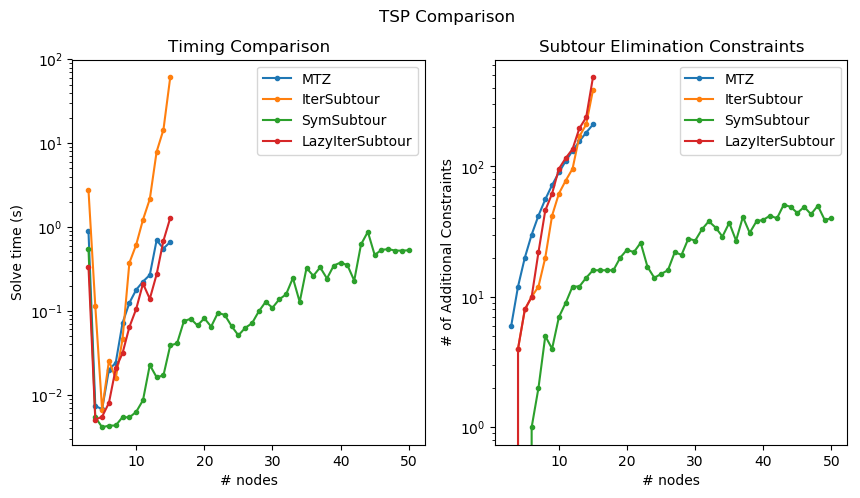

In [14]:
if !isdefined(:algorithms)
    error("You must run the above notebook cell before this one! (run the previous one twice, for accurate timing)")
end

# plot timing results
using PyPlot
fig = figure("TSP Comparison", figsize=(10,5))
suptitle("TSP Comparison")
subplot("121")
title("Timing Comparison")
yscale("log")
xlabel("# nodes")
ylabel("Solve time (s)")
for (nm, val) in algorithms
    plot(val[2], val[3], ".-", label=nm)
end
legend();

# plot additional constraint results
subplot("122")
title("Subtour Elimination Constraints")
yscale("log")
xlabel("# nodes")
ylabel("# of Additional Constraints")
for (nm, val) in algorithms
    plot(val[2], val[4], ".-", label=nm)
end
legend();
savefig("TSP_Comparison_Chart.png")